In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janatahack-customer-segmentation/Test.csv
/kaggle/input/janatahack-customer-segmentation/Train.csv
/kaggle/input/janatahack-customer-segmentation/sample_submission.csv


In [2]:
import matplotlib 
from matplotlib import rcParams
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import impute
from sklearn import ensemble
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/janatahack-customer-segmentation/Train.csv")
test = pd.read_csv("/kaggle/input/janatahack-customer-segmentation/Test.csv")
submission = pd.read_csv("/kaggle/input/janatahack-customer-segmentation/sample_submission.csv")

In [4]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
print(train.shape)
print(test.shape)

(8068, 11)
(2627, 10)


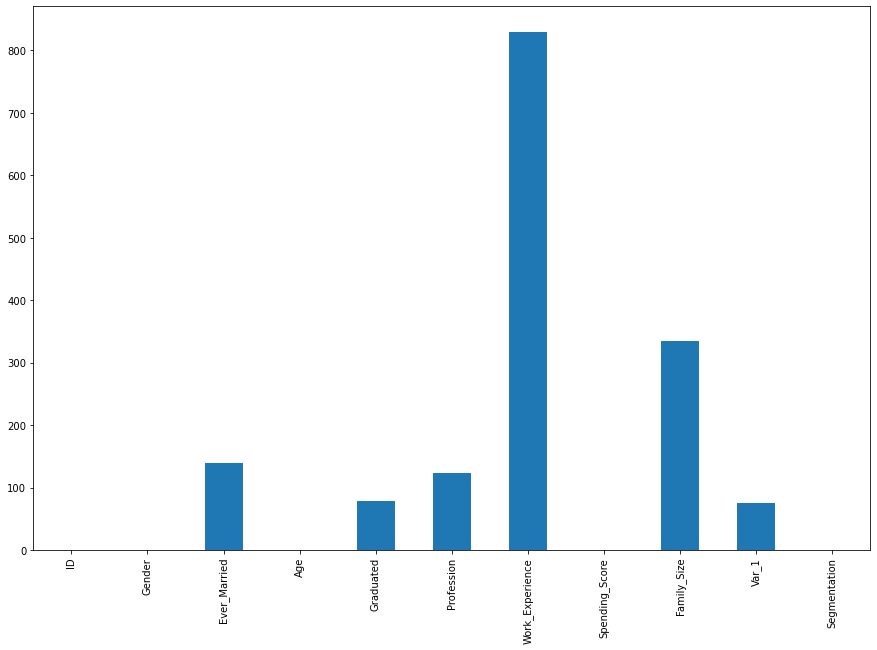

In [6]:
rcParams["figure.figsize"] = 15,10
train.isna().sum().plot(kind="bar")

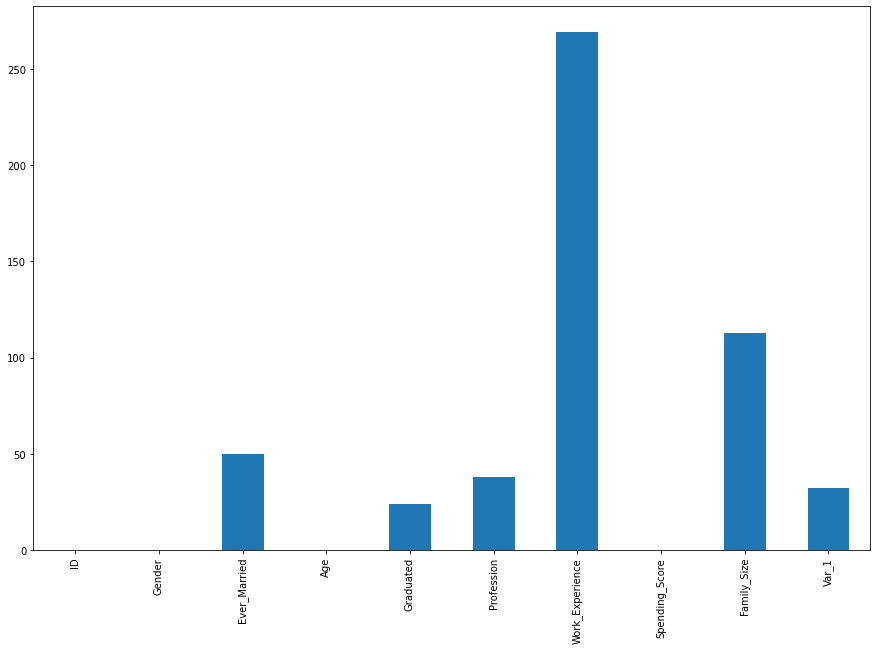

In [7]:
rcParams["figure.figsize"] = 15,10
test.isna().sum().plot(kind="bar")

In [8]:
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = impute.SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [9]:
train_most_frequent.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [10]:
test_most_frequent = test.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = impute.SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
test_most_frequent.iloc[:,:] = mean_imputer.fit_transform(test_most_frequent)

In [11]:
test_most_frequent.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [12]:
train_most_frequent.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000,8068.000000
mean,463479.214551,43.466906,2.472980,2.814824
std,2595.381232,16.711696,3.265248,1.508841
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,2.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [13]:
train_most_frequent["kfold"] = -1
train_most_frequent = train.sample(frac=1).reset_index(drop=True)

y = train_most_frequent.Segmentation.values

kf =model_selection.StratifiedKFold(n_splits=5)

for f,(t_,v_) in enumerate(kf.split(X=train_most_frequent,y=y)):
    train_most_frequent.loc[v_,'kfold'] = f

In [14]:
train_most_frequent.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,kfold
0,459732,Male,Yes,72,Yes,Executive,1.0,High,5.0,Cat_6,A,0.0
1,466953,Male,Yes,42,Yes,Artist,2.0,Average,2.0,Cat_6,B,0.0
2,461305,Male,No,22,No,Healthcare,1.0,Low,3.0,Cat_6,D,0.0
3,463003,Male,Yes,37,Yes,Artist,2.0,Average,2.0,Cat_6,C,0.0
4,459510,Female,No,23,No,Healthcare,0.0,Low,3.0,Cat_6,D,0.0


In [15]:
test_most_frequent["Ever_Married"].value_counts()

Yes    1570
No     1057
Name: Ever_Married, dtype: int64

In [16]:
lb1 = preprocessing.LabelEncoder()
lb = preprocessing.LabelEncoder()

In [17]:
train_most_frequent["Spending_Score"] = lb.fit_transform(train_most_frequent["Spending_Score"])
train_most_frequent["Gender"] = lb.fit_transform(train_most_frequent["Gender"])
train_most_frequent["Ever_Married"] = lb.fit_transform(train_most_frequent["Ever_Married"].astype(str))
train_most_frequent["Profession"] = lb.fit_transform(train_most_frequent["Profession"].astype(str))
train_most_frequent["Var_1"] = lb.fit_transform(train_most_frequent["Var_1"].astype(str))
train_most_frequent["Graduated"] = lb.fit_transform(train_most_frequent["Graduated"].astype(str))
train_most_frequent["Segmentation"] = lb1.fit_transform(train_most_frequent["Segmentation"].astype(str))


In [18]:
train_most_frequent.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,kfold
0,459732,1,1,72,1,4,1.0,1,5.0,5,0,0.0
1,466953,1,1,42,1,0,2.0,0,2.0,5,1,0.0
2,461305,1,0,22,0,5,1.0,2,3.0,5,3,0.0
3,463003,1,1,37,1,0,2.0,0,2.0,5,2,0.0
4,459510,0,0,23,0,5,0.0,2,3.0,5,3,0.0


In [19]:
train_most_frequent.ID.nunique()

8068

In [20]:
train["Segmentation"].value_counts()

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

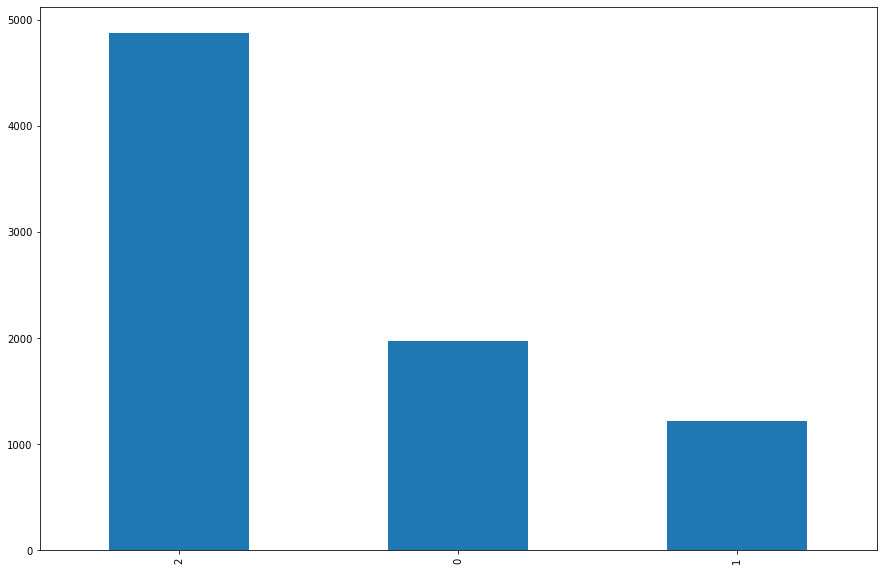

In [21]:
train_most_frequent["Spending_Score"].value_counts().plot(kind="bar")

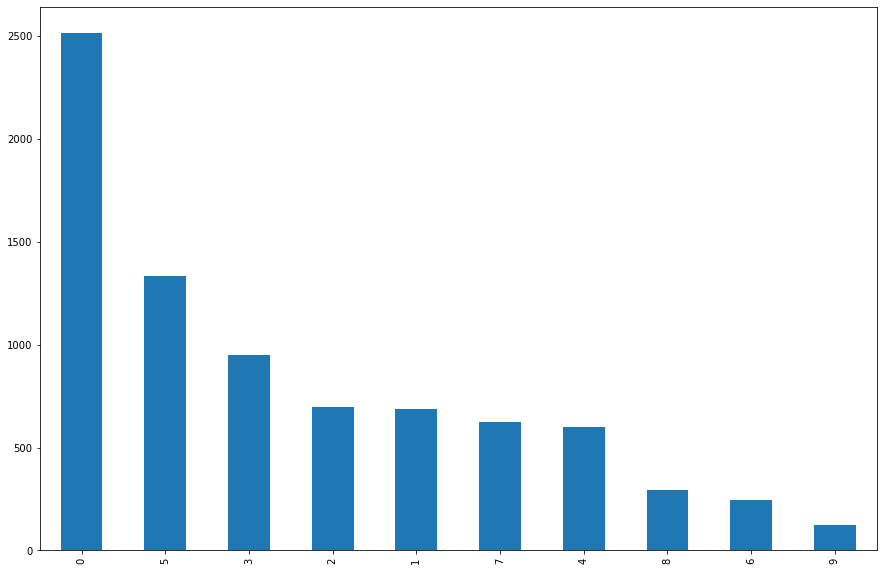

In [22]:
train_most_frequent["Profession"].value_counts().plot(kind="bar")

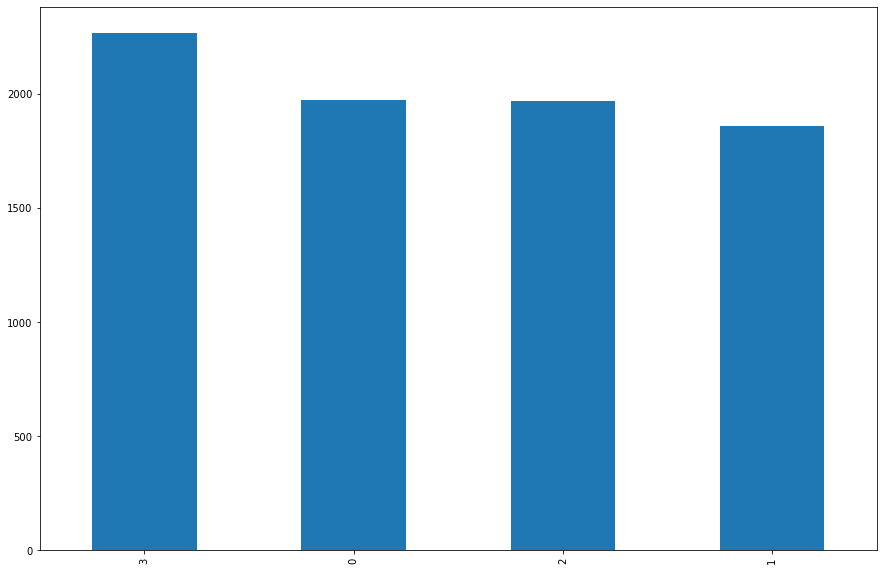

In [23]:
train_most_frequent["Segmentation"].value_counts().plot(kind="bar")

In [39]:
def run(train,fold):
    scores = []

    df_train = train[train.kfold !=fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)
    df_train = df_train.drop(["kfold",],axis=1)
    df_valid = df_valid.drop(["kfold",],axis=1)
    
    x_train = df_train.drop(["Segmentation"],axis=1)
    y_train = df_train["Segmentation"].values
    
    x_valid = df_valid.drop(["Segmentation"],axis=1)
    y_valid = df_valid["Segmentation"].values
    
#     model = cat.CatBoostClassifier(cat_features=["Gender","Ever_Married","Graduated","Profession","Var_1"])
    model = lgb.LGBMClassifier(n_estimators = 1000, min_samples_in_leaf = 10, learning_rate = .02, 
                          feature_fraction = .8, max_depth = 8)
    model.fit(x_train, y_train)
    preds = model.predict(x_valid)
    score = metrics.accuracy_score(y_valid, preds)
    print(f"Fold = {fold}, AUC = {score}")

In [40]:
for fold_ in range(0,5):
    run(train=train_most_frequent,fold=fold_)

Fold = 0, AUC = 0.5371747211895911
Fold = 1, AUC = 0.5359355638166047
Fold = 2, AUC = 0.5421313506815365
Fold = 3, AUC = 0.5350278983261004
Fold = 4, AUC = 0.5393676379417235


In [38]:
def run(train,fold):
    scores = []

    df_train = train[train.kfold !=fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)
    df_train = df_train.drop(["kfold"],axis=1)
    df_valid = df_valid.drop(["kfold"],axis=1)
    
    x_train = df_train.drop(["Segmentation"],axis=1)
    y_train = df_train["Segmentation"].values
    
    x_valid = df_valid.drop(["Segmentation"],axis=1)
    y_valid = df_valid["Segmentation"].values
    
    model = xgb.XGBClassifier(objective="multi:softmax",eval_metric="auc",learning_rate =0.1,
                                                         n_estimators=1000,
                                                         max_depth=5,
                                                         min_child_weight=1,
                                                         gamma=0,
                                                         subsample=0.8,
                                                         colsample_bytree=0.8,)
    model.fit(x_train, y_train)
    preds = model.predict(x_valid)
    score = metrics.accuracy_score(y_valid, preds)
    print(f"Fold = {fold}, AUC = {score}")

In [37]:
for fold_ in range(0,5):
    run(train=train_most_frequent,fold=fold_)

Fold = 0, AUC = 0.5216852540272615
Fold = 1, AUC = 0.5241635687732342
Fold = 2, AUC = 0.5216852540272615
Fold = 3, AUC = 0.5319280843149411
Fold = 4, AUC = 0.5263484190948543


In [28]:
test_most_frequent["Spending_Score"] = lb.fit_transform(test_most_frequent["Spending_Score"])
test_most_frequent["Gender"] = lb.fit_transform(test_most_frequent["Gender"])
test_most_frequent["Ever_Married"] = lb.fit_transform(test_most_frequent["Ever_Married"].astype(str))
test_most_frequent["Profession"] = lb.fit_transform(test_most_frequent["Profession"].astype(str))
test_most_frequent["Var_1"] = lb.fit_transform(test_most_frequent["Var_1"].astype(str))
test_most_frequent["Graduated"] = lb.fit_transform(test_most_frequent["Graduated"].astype(str))

In [29]:
train_most_frequent.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,kfold
0,459732,1,1,72,1,4,1.0,1,5.0,5,0,0.0
1,466953,1,1,42,1,0,2.0,0,2.0,5,1,0.0
2,461305,1,0,22,0,5,1.0,2,3.0,5,3,0.0
3,463003,1,1,37,1,0,2.0,0,2.0,5,2,0.0
4,459510,0,0,23,0,5,0.0,2,3.0,5,3,0.0


In [30]:
x = train_most_frequent.drop(["Segmentation","kfold"],axis=1)
y = train_most_frequent["Segmentation"]

In [43]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax",n_jobs=-1,num_class=4,eval_metric="auc",learning_rate =0.1,
                                                         n_estimators=1000,
                                                         max_depth=5,
                                                         min_child_weight=1,
                                                         gamma=0,
                                                         subsample=0.8,
                                                         colsample_bytree=0.8,)
xgb_model.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [41]:
lgb_model = lgb.LGBMClassifier(n_estimators = 1000, min_samples_in_leaf = 10, learning_rate = .02, feature_fraction = .8, max_depth = 8)
lgb_model.fit(x,y)

LGBMClassifier(feature_fraction=0.8, learning_rate=0.02, max_depth=8,
               min_samples_in_leaf=10, n_estimators=1000)

# Ensembel Model

In [44]:
model_voting = ensemble.VotingClassifier([('xgboost', xgb_model), ('lightgbm', lgb_model)], 
                                         voting = 'soft').fit(x, y)

In [45]:
y_pred = model_voting.predict(test_most_frequent)

In [46]:
new_y_pred = lb1.inverse_transform(y=y_pred)

In [47]:
new_y_pred

array(['B', 'C', 'B', ..., 'A', 'B', 'D'], dtype=object)

In [48]:
submission["Segmentation"]=new_y_pred
submission.to_csv("av_ensembled.csv",index=False)